In [1]:
import pystan
import pylab as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns

# MindLab Model for shelving
There are three variables that could effect whether an item is selected, `product_index`, `product` and `price`. We want to be able to marginalise out product and price to see effect of shelf position (`product_index`). As there is a binary input put from the user, the model will have to be based on the logisitic model:

$$ \mathrm{logit}[\mathrm{p}(y_{ij}=1|,\alpha_{i},\beta_{i},\gamma_{i})] = f(\alpha_{i},\beta_i,\gamma_{i})  $$

* $y_{ij}$ is the response for person $j$ to a particular product ($\alpha_{i}$) at a particular price ($\beta_{i}$)   and location on shelf ($\gamma_{i}$) i.e. `fit`=1 or `does not fit`=0
* $\alpha_{i} $ is product (discrete)
* $\beta_i$ is price (continuous)
* $\gamma_{i}$ is position (discrete)

The key is coming up with the function ($f$)

For our second model, we will still assume a linear relationship between price and product placement:
$$m*\beta_{i}+c_{\gamma_{i}}$$
where:
* $m$ is slope, telling us how much price affects selection
* $c$ is intercept, telling us how much product position changes selection

However, we will now introduce a hierarchical element to the intercept, such that there is a global mean intercept for all positions. I will model this with a multi D Gaussian, such that correlations between the positions are also picked up.

## Build the model

In [187]:
model="""
data {
  int<lower=1> K;              // number of product places
  int<lower=1> N;              // number of observations
  vector[N] price;  //product price for observation n
  int<lower=1,upper=K> kk[N];  // product place for observation n
  int<lower=0,upper=1> y[N];   // selected or not for observation n
  int<lower=0> nprice; //number of price points
  vector[nprice] price_pred; //price points for predictions
  int<lower=1> P; //number of products
  int<lower=1> product[N]; //product for observation n
}

parameters {
  vector[K] c_raw[P];              // effect of place for k
  real m[P]; // slope;
  vector[K] hier_c_mean; 
  cholesky_factor_corr[K] L_Omega;
  vector<lower=0>[K] tau;      // prior scale

  
  }

transformed parameters {
vector[K] c[P];

for (i in 1:P){
c[i]=hier_c_mean + (diag_pre_multiply(tau,L_Omega) * c_raw[i]);
}

}


model {
for (i in 1:P){
m[i] ~ std_normal();
c_raw[i] ~std_normal();
}
hier_c_mean~normal(0,3);
L_Omega ~ lkj_corr_cholesky(2);
tau ~ normal(0, 1);

  if (N > 1){
  for (i in 1:N){
  y[i] ~ bernoulli_logit(m[product[i]]*price[i] + c[product[i],kk[i]]);
  }
  }
}

generated quantities {
vector[N] y_rep;
matrix[nprice,K] pred_matrix[P];
matrix[nprice,K] pred_matrix_select[P];
if (N<2)
for (i in 1:nprice){
for (j in 1:K){
for (z in 1:P){
pred_matrix[z,i,j]=m[z]*price_pred[i] + c[z,j];
pred_matrix_select[z,i,j]=bernoulli_logit_rng(pred_matrix[z,i,j]);
}
}
}
if (N > 1){
for (i in 1:N){
y_rep[i] = bernoulli_logit_rng(m[product[i]]*price[i] + c[product[i],kk[i]]);
}
}
}
"""

In [188]:
sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_283c6df712c63ff278373a00df2c1027 NOW.


In [189]:
data={
    'K':5,
    'N':1,
    'price':[0],
    'kk':[1],
    'y':[1],
    'nprice':10,
    'price_pred':np.arange(-5,5,1.0),
    'P':8,
    'product':[1]
}

In [190]:
fit=sm.sampling(data=data,chains=1,iter=500)

In [191]:
fit

/opt/conda/lib/python3.7/site-packages/pystan/misc.py:355: RuntimeWarning: invalid value encountered in sqrt
  sem=msd[:, 1] / np.sqrt(ess), ess=ess, rhat=rhat,



For the full summary use 'print(fit)'

Inference for Stan model: anon_model_283c6df712c63ff278373a00df2c1027.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_raw[1,1]       0.01    0.06   1.11  -2.18  -0.65   0.02   0.78   2.24    362    1.0
c_raw[2,1]      -0.05    0.05   0.99   -2.1  -0.78  -0.03   0.66   1.97    452    1.0
c_raw[3,1]       0.02    0.04   1.02  -1.99  -0.61   0.03   0.68   2.01    753    1.0
c_raw[4,1]      -0.02    0.05   1.03   -2.2   -0.7   0.04   0.71   2.06    520    1.0
c_raw[5,1]       0.03    0.03   1.02  -1.79  -0.75   0.03   0.76   2.11   1172    1.0
c_raw[6,1]      -0.08    0.05   0.99  -2.08   -0.8  -0.06   0.63   1.76    344    1.0
c_raw[7,1]       0.01    0.04   0.96  -2.03  -0.53   0.02   0.59   1.95    723    1.0
c_raw[8,1]      -0.03    0.05   1.02  -2.01  -0.74  -0.03   0.69   1.94    485    1.0
c

<Figure size 720x720 with 0 Axes>

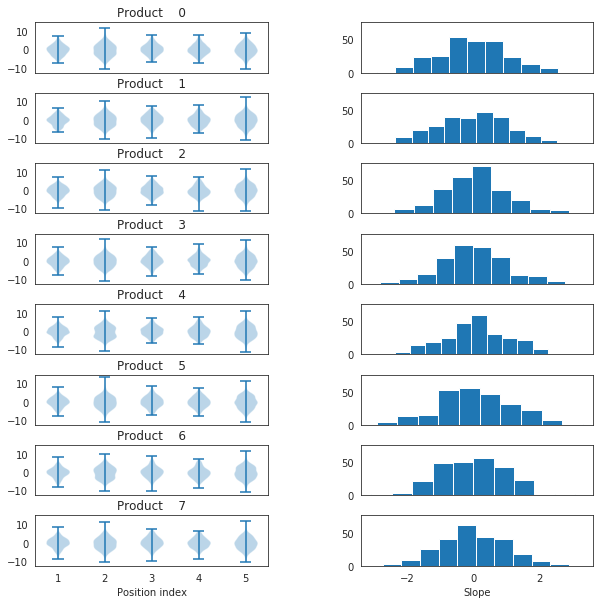

In [192]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(fit.data['P'], 2, sharex='col', sharey='col',figsize=(10,10))
for i in range(0,fit.data['P']):
    ax[i,0].violinplot(fit['c'][:,i,:]);
    ax[i,1].hist(fit['m'][:,i]);
    ax[i,0].set_title('Product {:4.0f}'.format(i))
ax[-1,0].set_xlabel('Position index')
ax[-1,1].set_xlabel('Slope')
fig.subplots_adjust(hspace=0.4, wspace=0.4)


The intercept and slopes for the different products

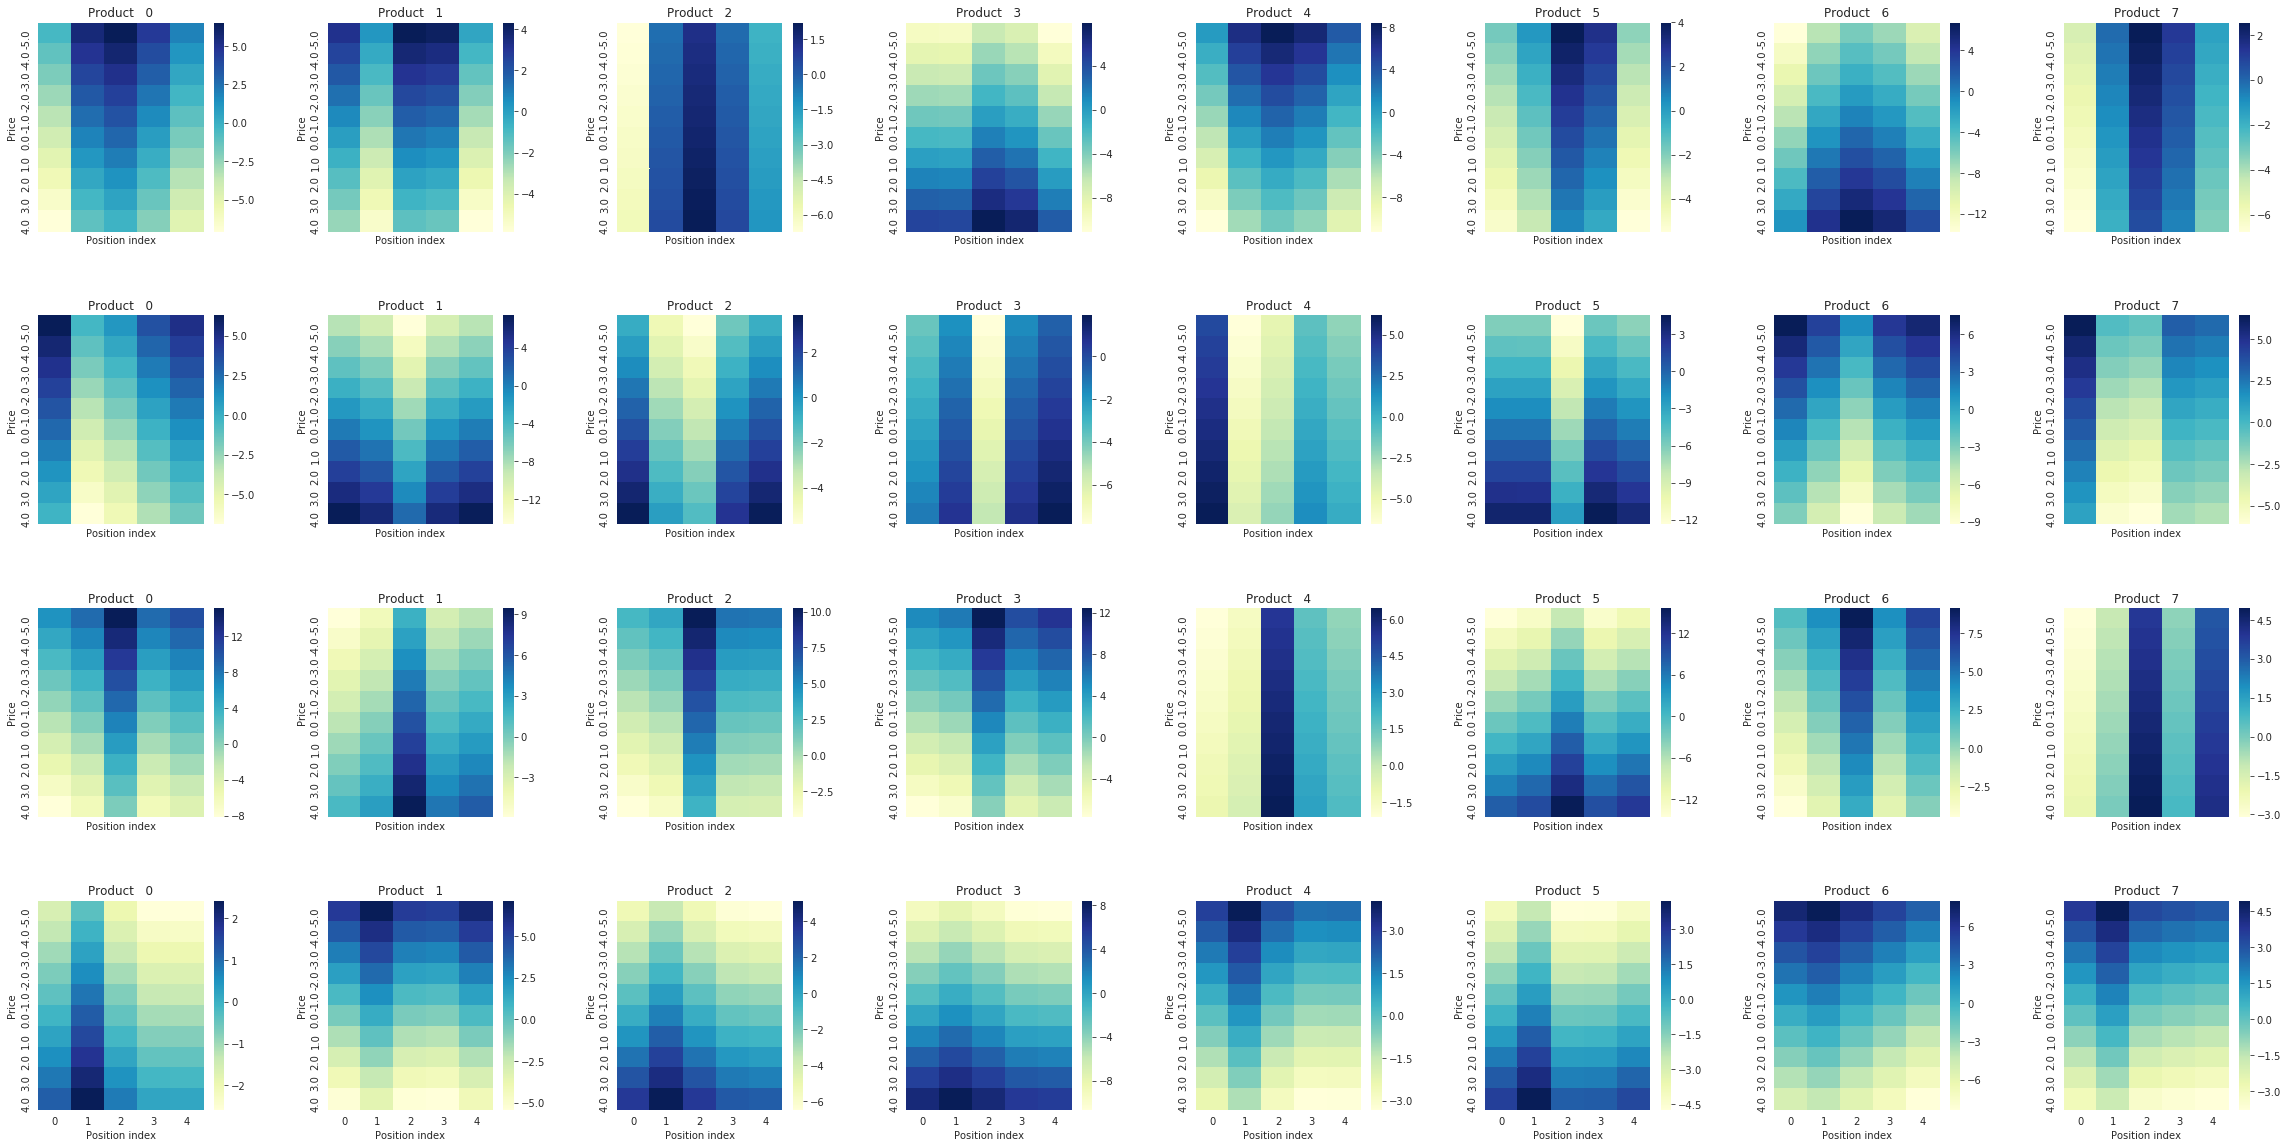

In [193]:
s=[0,1,2,10]
fig, ax = plt.subplots(len(s), fit.data['P'], sharex='col', sharey='col',figsize=(40,20))

for i in range(0,len(s)):
    for p in range(0,fit.data['P']):
        sns.heatmap(fit['pred_matrix'][s[i],p,:,:],yticklabels=fit.data['price_pred'],cmap="YlGnBu",ax=ax[i,p],)
        ax[i,p].set_xlabel('Position index')
        ax[i,p].set_ylabel('Price')
        ax[i,p].set_title(r'Product{:4.0f}'.format(p))
    #sns.heatmap(fit['pred_matrix_select'][s[i],:,:],yticklabels=fit.data['price_pred'],cmap="YlGnBu",ax=ax[i,1])

fig.subplots_adjust(hspace=0.4, wspace=0.4)


A plot showing the different prediction matrices for different products in each row. Each row is a different sample from the prior. Note how there is a similar effect from certian positions in each row. This is coming from the hierarchical prior.

Text(0.5, 0, 'positions')

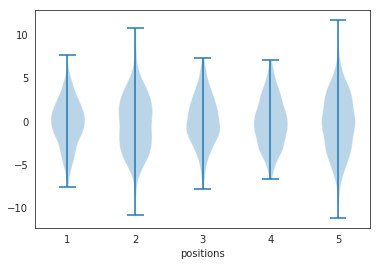

In [194]:
plt.violinplot(fit['hier_c_mean'])
plt.xlabel('positions')

The hierarchical mean values for position

## Fit prior samples

In [195]:
def zscore(posterior, truth):
    return np.abs((np.mean(posterior)-truth)/np.std(posterior))
def shrinkage(posterior,prior):
    return 1-(np.var(posterior)/np.var(prior))

In [196]:
def get_indicators(N, M, prob_std=0.5):
    ind = np.random.binomial(1, prob_std, (N, M))
    return ind>0

In [197]:
zscore_prior_pred_c=np.empty((fit.data['P'],fit.data['K'],10))
zscore_prior_pred_m=np.empty((fit.data['P'],10))
shrinkage_prior_pred_c=np.empty((fit.data['P'],fit.data['K'],10))
shrinkage_prior_pred_m=np.empty((fit.data['P'],10))
zscore_hier_mean=np.empty((fit.data['K'],10))
zscore_hier_sig=np.empty((fit.data['K'],10))
shrinkage_hier_mean=np.empty((fit.data['K'],10))
shrinkage_hier_sig=np.empty((fit.data['K'],10))


for s in range(0,10):
    data_prior={
        'K':fit.data['K'],
        'N':fit['pred_matrix'][s,:,:,:].flatten().size,
        'price':np.tile(np.repeat(np.arange(-5,5,1.0),fit.data['K']),fit.data['P']),
        'kk':np.tile(np.tile(np.arange(1,6,1),10),fit.data['P']),
        'y':fit['pred_matrix_select'][s,:,:].flatten().astype(int),
        'nprice':10,
        'price_pred':np.arange(-5,5,1.0),
        'P':8,
        'product':np.repeat(np.arange(1,fit.data['P']+1),fit.data['K']*fit.data['nprice'])
        }
    fit_prior=sm.sampling(data=data_prior)
    zscore_prior_pred_c[:,:,s]=zscore(fit_prior['c'],fit['c'][s,:,:])
    for j in range(0,fit.data['P']):
        shrinkage_prior_pred_m[j,s]=shrinkage(fit_prior['m'][:,j],fit['m'][:,j])
        for i in range(0,fit.data['K']):
            shrinkage_prior_pred_c[j,i,s]=shrinkage(fit_prior['c'][:,j,i],fit['c'][:,j,i])
    zscore_prior_pred_m[:,s]=zscore(fit_prior['m'],fit['m'][s])
    zscore_hier_mean[:,s]=zscore(fit_prior['hier_c_mean'],fit['hier_c_mean'][s])
    #zscore_hier_sig[:,s]=zscore(fit_prior['hier_c_sig'],fit['hier_c_sig'][s])
    for i in range(0,fit.data['K']):
        shrinkage_hier_mean[i,s]=shrinkage(fit_prior['hier_c_mean'][:,i],fit['hier_c_mean'][:,i])
        #shrinkage_hier_sig[i,s]=shrinkage(fit_prior['hier_c_sig'][:,i],fit['hier_c_sig'][:,i])

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


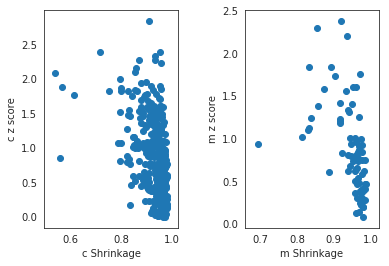

In [198]:
plt.subplot(1,2,1)
plt.scatter(shrinkage_prior_pred_c,zscore_prior_pred_c)
plt.xlabel('c Shrinkage')
plt.ylabel('c z score')
plt.subplot(1,2,2)

plt.scatter(shrinkage_prior_pred_m,zscore_prior_pred_m)
plt.xlabel('m Shrinkage')
plt.ylabel('m z score')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

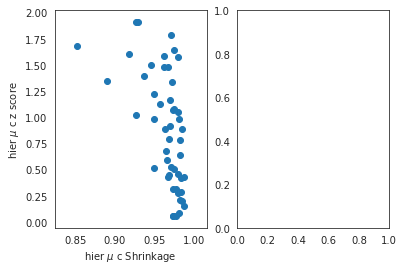

In [199]:
plt.subplot(1,2,1)
plt.scatter(shrinkage_hier_mean,zscore_hier_mean)
plt.xlabel('hier $\mu$ c Shrinkage')
plt.ylabel('hier $\mu$ c z score')
plt.subplot(1,2,2)


# Fit model to data
At the moment the model is built for one person and one product. We could assume everyone acts the same as a first pass and fit for every object.

In [7]:
data=pd.read_csv('../../../data/raw/priced_shelves_data.csv')
data['id.session_int']=data.groupby('id.session').grouper.group_info[0]+1
data['selected_int']=data.groupby('selected').grouper.group_info[0]
data['product_int']=data.groupby('product').grouper.group_info[0]+1
data['mean_sub_price']=data['price']-data.groupby('product').transform('mean')['price']


In [201]:
ind=data['product_int']<15

In [202]:
len(data[ind])

96824

In [203]:
data_infer={
    'K':data['product_index'].unique().size,
    'N':len(data[ind]),
    'price':data[ind]['mean_sub_price'],
    'kk':data[ind]['product_index'].values+1,
    'y':data[ind]['selected_int'],
    'nprice':9,
    'price_pred':np.arange(8,17,1.0),
    'P':data[ind]['product_int'].unique().size,
    'product':data[ind]['product_int']
    }


In [204]:
fit_infer=sm.sampling(data=data_infer,chains=2,iter=1000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [205]:
pystan.check_hmc_diagnostics(fit_infer)

{'n_eff': False,
 'Rhat': False,
 'divergence': False,
 'treedepth': True,
 'energy': True}

In [206]:
fit_infer


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_283c6df712c63ff278373a00df2c1027.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_raw[1,1]    0.01    0.02   0.98  -1.86  -0.64 8.1e-4   0.72   1.87   2160    1.0
c_raw[2,1]    0.01    0.02   1.05  -2.11  -0.73   0.02    0.7   2.13   1913    1.0
c_raw[3,1]   -0.02    0.02   1.05  -2.04  -0.75 9.7e-3    0.7   1.96   1764    1.0
c_raw[4,1]  4.0e-4    0.02   1.03   -2.0  -0.73   0.04   0.71   2.07   2204    1.0
c_raw[5,1]   -0.02    0.03   0.98  -1.85  -0.69 7.6e-4   0.67    1.9   1452    1.0
c_raw[6,1]    0.03    0.03    1.0  -1.97  -0.61   0.03   0.66   2.02   1523    1.0
c_raw[7,1]   -0.02    0.03   1.04  -2.09  -0.77 5.4e-3   0.66   2.04   1472    1.0
c_raw[8,1] -6.4e-3    0.03   1.03  -2.03  -0.69  -0.02   0.67   2.07   1409    1.0
c_raw[9,1]    -0.5    0.03

### Save the model and fit

In [261]:
import pickle
with open("model_fit_new_prior.pkl", "wb") as f:
    pickle.dump({'model' : sm, 'fit' : fit_infer}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


### Load the model and fit

In [2]:
import pickle
with open("model_fit_new_prior.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
fit_infer = data_dict['fit']

# fit = data_list[1]

### Hierarchical parameters

#### $\Sigma$: The covariance matrix for hierarchical position

In [255]:
Sigma=np.empty((fit_infer['tau'].shape[0],fit_infer['tau'].shape[1],fit_infer['tau'].shape[1]))
for s in range(0,fit_infer['tau'].shape[0]):
    Sigma[s,:,:]=np.matmul(np.diag(fit_infer['tau'][s,:]),np.matmul(np.matmul(fit_infer['L_Omega'][s,:,:],fit_infer['L_Omega'][s,:,:].T),np.diag(fit_infer['tau'][s,:])))

In [256]:
np.mean(Sigma,axis=0)

(14, 14)

Text(0.5, 1.0, 'Std. Dev. $\\Sigma$')

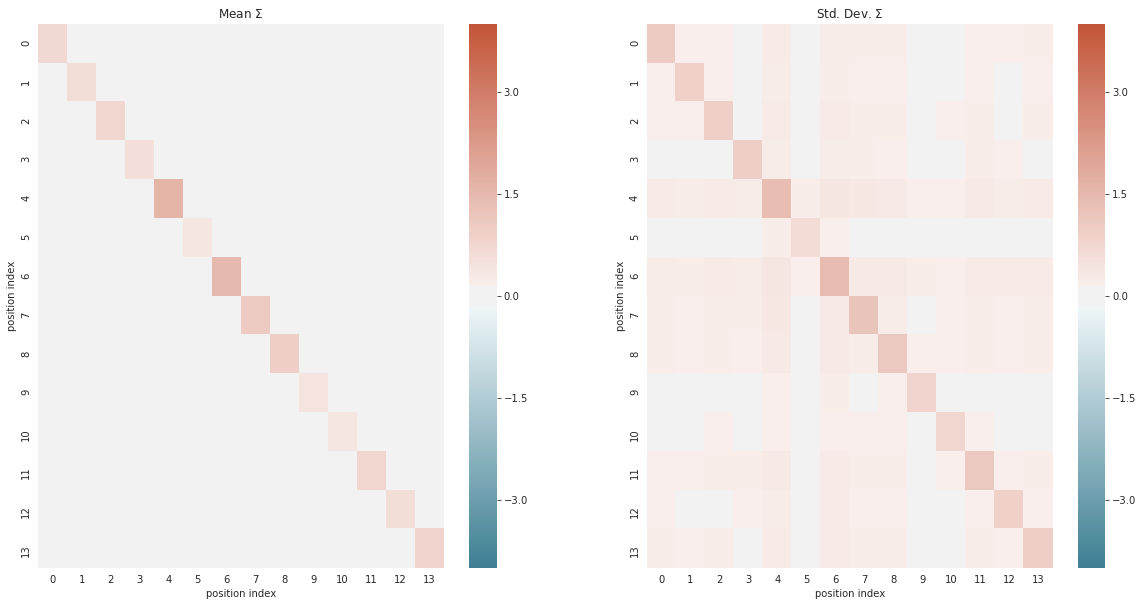

In [260]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.heatmap(np.mean(Sigma,axis=0),cmap=sns.diverging_palette(220, 20, as_cmap=True),vmin=-4,vmax=4)
plt.xlabel('position index')
plt.ylabel('position index')
plt.title('Mean $\Sigma$')
plt.subplot(1,2,2)
sns.heatmap(np.std(Sigma,axis=0),cmap=sns.diverging_palette(220, 20, as_cmap=True),vmin=-4,vmax=4)
plt.xlabel('position index')
plt.ylabel('position index')
plt.title('Std. Dev. $\Sigma$')

The plot above shows the mean and standard deviation for the covariance matrix related to the hierarchical position parameter. The off-diagonal elements of the covariance matrix tells us how the positions are related with one another. For example,
* if the off-diagonal elements are positive, it means if the clicks for a particular project are high in one position, they will be high in the second position
* If the off-diagonal elements are negative, it means if the clicks for a particular project are high in one position, they will be low in the second position.
* If the off-diagonal elements are close to zero, then there is no correlation between positions.

As can be seen in the plots above, the mean off-diagnonal elements are close to zero so, given the data we have, there does not appear to be much correlation between positions.

The diagonal elements are the traditional $\sigma^2$ for each position. The larger the $\sigma^2$, the more dispersion on the position parameter, with the intuitive interpretation of this is that different products behave differently at the same position, where as smaller $\sigma^2$ would indicate that different products find a similar effect for position.



#### $\sigma$: Marginalised uncertianty on hierarchical position
This is another way of visualising the diagnonal elements of the covariance matrix

Text(0, 0.5, 'Hierarchical C $\\sigma^2_{ii}$')

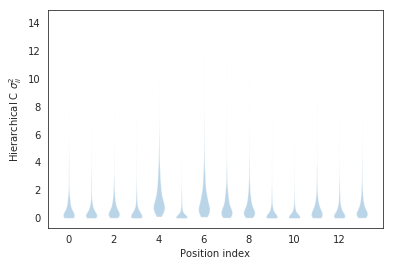

In [208]:
plt.violinplot(fit_infer['tau'][:,:]**2,showextrema=False,positions=data['product_index'].unique());
plt.xlabel('Position index')
plt.ylabel(r'Hierarchical C $\sigma^2_{ii}$')

#### $\mu$: Mean hierarchical position
This parameter gives us the mean position for the hierarchical distribution. A position that has a lower mean C will have less chance of being selected. The plot above shows the posterior probability distribution of the mean hierarchical c value.

Text(0, 0.5, 'Hierarchical C Mean')

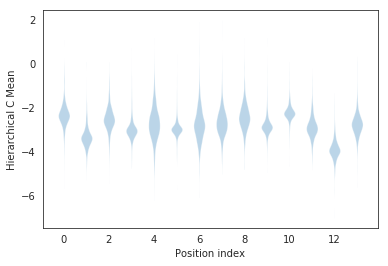

In [209]:
plt.violinplot(fit_infer['hier_c_mean'],showextrema=False,positions=data['product_index'].unique());
plt.xlabel('Position index')
plt.ylabel('Hierarchical C Mean')

#### Full distribution on hierarchical position and relevance for individual position parameters
So far, we have looked at the mean and covariance matrix for the hierarchical parameters. In this model, we are assuming the distribution of c values for each product follows a normal distribtion, with a mean and covariance matrix given above. However, we have uncertainty on the mean and covariance as already demonstrated. We can propagate that uncertainty through to get the full hierarchical probability distribution for C, for which the indivual c values for each product are drawn from. 

The plot below shows that propagated distribution, with the posterior probability distribution for the individual c values plotted on top for each product. Because of the limited number of positions tried for each product in this dataset, the distributions are not that informative.

In [212]:
hier_dist=np.zeros((10,fit_infer['hier_c_mean'].shape[0],fit_infer['hier_c_mean'].shape[1]))
for i in range(0,fit_infer['hier_c_mean'].shape[0],100):
    for z in range(0,fit_infer['hier_c_mean'].shape[1]):
        hier_dist[:,i,z]=np.random.normal(fit_infer['hier_c_mean'][i,z],fit_infer['tau'][i,z]**2,10)


Text(0, 0.5, 'C')

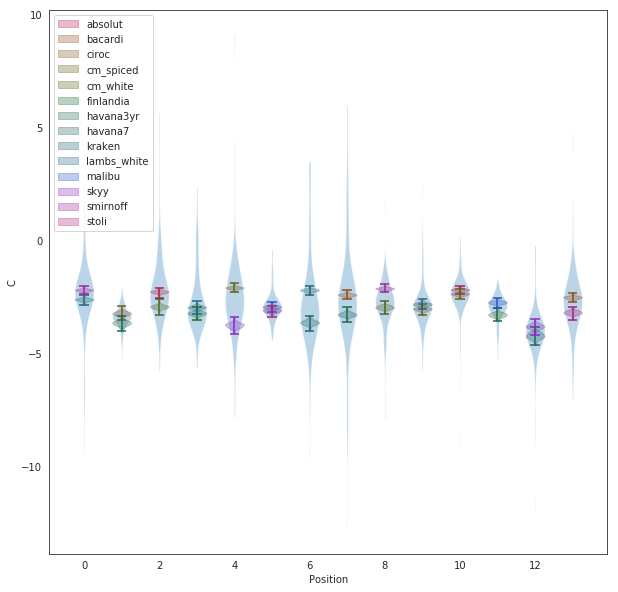

In [248]:
import matplotlib.patches as mpatches

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

plt.figure(figsize=(10,10))
labels=[]
c=sns.husl_palette(np.unique(fit_infer.data['product'].values).size,l=.4)
plt.violinplot(hier_dist[:,::100,:].reshape(100,14),showextrema=False,positions=data['product_index'].unique());
for z,pro in enumerate(np.unique(fit_infer.data['product'].values)):
    ind=fit_infer.data['product']==pro
    violin_parts=plt.violinplot(fit_infer['c'][:,z,np.unique(fit_infer.data['kk'][ind])-1],positions=np.unique(fit_infer.data['kk'][ind])-1);
    for pc in violin_parts['bodies']:
            pc.set_facecolor(c[z])
            pc.set_edgecolor(c[z])
    for pc in [violin_parts[i] for i in ['cbars','cmins','cmaxes']]:
            pc.set_facecolor(c[z])
            pc.set_edgecolor(c[z])
    add_label(violin_parts,np.unique(data[data['product_int']==pro]['product'])[0])
plt.legend(*zip(*labels), loc=2)
plt.xlabel('Position')
plt.ylabel('C')

### Slopes (m): The impact of price

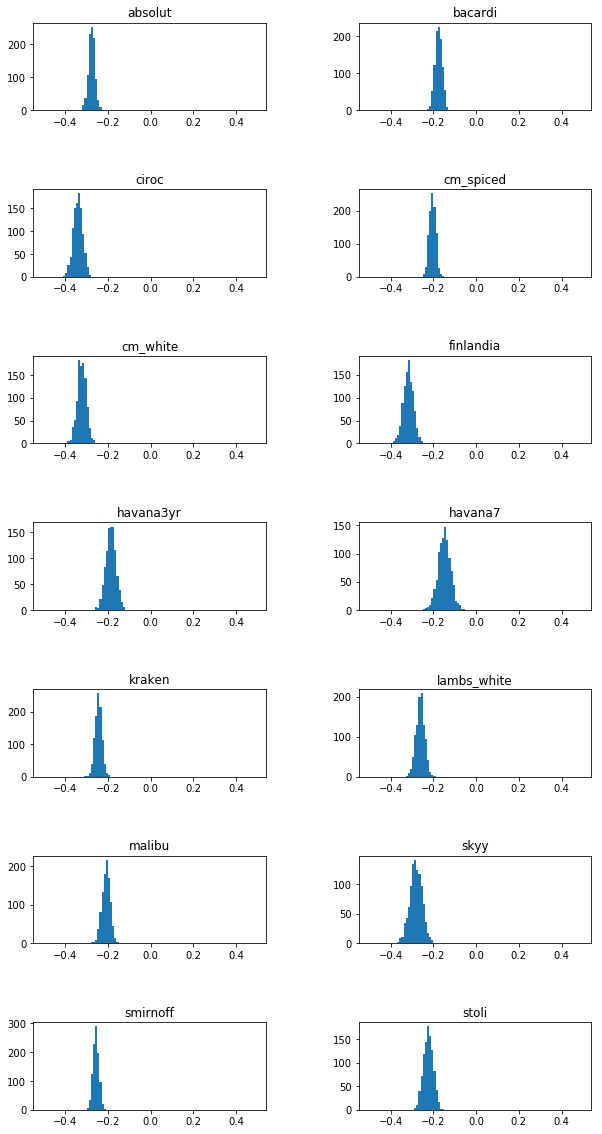

In [15]:
plt.figure(figsize=(10,20))
for z,pro in enumerate(np.unique(fit_infer.data['product'].values)):
    plt.subplot(7,2,z+1)
    plt.hist(fit_infer['m'][:,z],bins=np.arange(-0.5,0.5,0.01));
    plt.title(np.unique(data[data['product_int']==pro]['product'])[0])
plt.subplots_adjust(hspace=0.9,wspace=0.4)

### Posterior predictive checks
When examining goodness of fits, the typical method is to compare the data with replicated data from the model, using the best result for parameters. Because we have a full posterior distribution of replicated data, which captures the uncertainty from our model (e.g. on parameters in the model), we can do this in a more probabilisitic way using posterior predictive checks. For more information on posterior predictive checks, Gelman et al. 1996 is a good starting point.

Its normally best to start with visual checks. For this, we can see whether the real number of selections over total for each product, price and position combination is consistent with the distribution from our model. The plots below shows this for each product, and the position they were placed in as a function of price.

In [216]:
counts_data=[]
counts_rep=[]
for z,pro in enumerate(np.unique(fit_infer.data['product'].values)):
    print(z)
    ind=fit_infer.data['product']==pro
    for i,pi in enumerate(np.unique(fit_infer.data['kk'][ind])):
        ind_2=(fit_infer.data['product']==pro) & (fit_infer.data['kk']==pi)
        for j,pri in enumerate(np.unique(fit_infer.data['price'][ind])):
            ind_all=(fit_infer.data['kk']==pi) & (fit_infer.data['price'].values == pri) & (fit_infer.data['product'].values == pro)
            ind_select=fit_infer.data['y'][ind_all].values==1
            counts_data.append([pro,pi,pri,ind_select.sum()/ind_all.sum()])
            ind_dist=fit_infer['y_rep'][:,ind_all]==1
            counts_rep.append([ind_dist.sum(axis=1)/ind_all.sum()])
            
counts_data=np.asarray(counts_data)
counts_rep=np.vstack(counts_rep).T

0
1
2
3
4
5
6
7
8
9
10
11
12
13


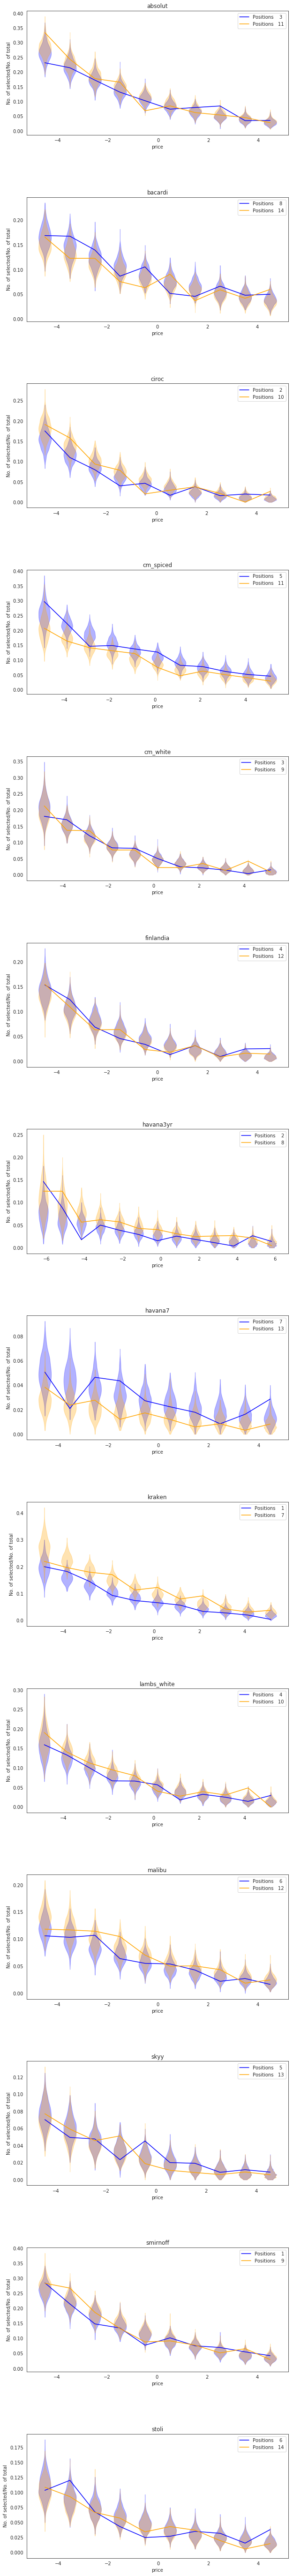

In [217]:
color=['blue','orange','green','red']

plt.figure(figsize=(10,100))
for z,pro in enumerate(np.unique(fit_infer.data['product'].values)):
    ind=fit_infer.data['product']==pro
    plt.subplot(np.unique(fit_infer.data['product'].values).size,1,z+1)
    for i,pi in enumerate(np.unique(fit_infer.data['kk'][ind])):
        ind_plot=(counts_data[:,0]==pro) & (counts_data[:,1]==pi)
        violin_parts=plt.violinplot(counts_rep[:,ind_plot],positions=counts_data[ind_plot,2],showextrema=False)
        for pc in violin_parts['bodies']:
            pc.set_facecolor(color[i])
            pc.set_edgecolor(color[i])
        plt.plot(counts_data[ind_plot,2],counts_data[ind_plot,3],color=color[i],label='Positions {:4.0f}'.format(pi))
        plt.legend()
        plt.title(np.unique(data[data['product_int']==pro]['product'])[0])
        plt.xlabel('price')
        plt.ylabel('No. of selected/No. of total')
plt.subplots_adjust(hspace=0.5,wspace=0.3)

The plot above shows the fraction selected over total for each price and position. The lines are from the data, the violin plots are the distributions for our replicated data. The replicated data distribution shows the uncertianty our model has in the fraction. If our model is doing a good job, the lines should roughly fall within the distributions.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':


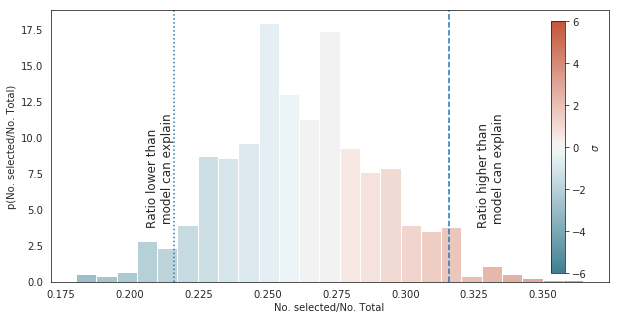

In [218]:
import seaborn as sns
import matplotlib as mpl
sns.set_style("white")

fig=plt.figure(figsize=(10,5))


# This is  the colormap I'd like to use.
cm = sns.diverging_palette(220, 20, as_cmap=True)

# Get the histogramp
Y,X = np.histogram(counts_rep[:,0], 25, normed=1)
#C = [cm(((x-X.min())/x_span)) for x in X]
C = [cm(((((x-np.mean(counts_rep[:,0]))/np.std(counts_rep[:,0]))+6)/12.0)) for x in X]


plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
plt.xlabel('No. selected/No. Total')
plt.ylabel('p(No. selected/No. Total)')
plt.axvline(np.mean(counts_rep[:,0])+0.05, linestyle='--')
plt.axvline(np.mean(counts_rep[:,0])-0.05,linestyle=':')
plt.annotate('Ratio higher than \n model can explain',xy=(np.mean(counts_rep[:,0])+0.06, 5),  xycoords='data',
            xytext=(np.mean(counts_rep[:,0])+0.06, 10), textcoords='data',rotation='vertical',size='large')
plt.annotate('Ratio lower than \n model can explain',xy=(np.mean(counts_rep[:,0])-0.06, 5),  xycoords='data',
            xytext=(np.mean(counts_rep[:,0])-0.06, 10), textcoords='data',rotation='vertical',size='large')

#ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax1 = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = mpl.colors.Normalize(vmin=-6, vmax=6)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('$\sigma$')

As well as carrying out posterior predictive checks visually, we can quantify the fit with something called a Bayesian P value.

We can calculate fraction of $y_{rep}$ samples above and below real ratio. This is often referred to as the Bayesian P-value and is telling us what the probability is of drawing the real ratio, from our model which has been inferred on the data. This is tells us if the model is inconsistent with the data, given the uncertianties in parameters and data.

* ∼0.5 (i.e. near the middle of the distribution) means our model is consistent with the data
* 0.99 or 0.01 (i.e. in the tails) means the model is missing something.

We can convert this to a typical '$\sigma$' level, such that $\sigma<−3$ or $\sigma>3$ indicates a problem with the model.

For more information on posterior predictive checks, see:


Bayesian Data Analysis
http://www.stat.columbia.edu/~gelman/research/published/philosophy.pdf

In [219]:
def Bayes_P_value(rep_data,obs_data):
    import scipy.stats as st
    pval=np.empty_like(obs_data)
    for i,d in enumerate(obs_data):
        ind=rep_data[:,i]<d
        pval[i]=st.norm.ppf(sum(ind)/rep_data.shape[0])
    return pval

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # This is added back by InteractiveShellApp.init_path()


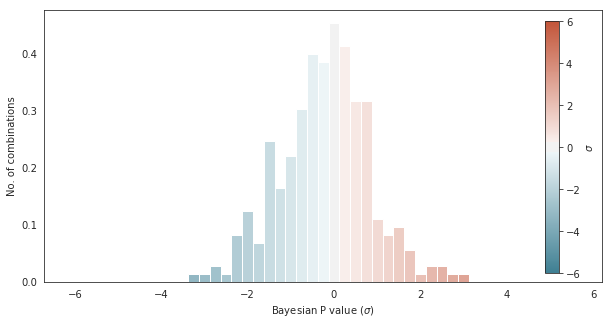

In [220]:
fig=plt.figure(figsize=(10,5))


# This is  the colormap I'd like to use.
cm = sns.diverging_palette(220, 20, as_cmap=True)

#calculate pvalues for all combinations of price, product and position
pvalues=Bayes_P_value(counts_rep,counts_data[:,3])

# Get the histogramp
Y,X = np.histogram(pvalues, np.arange(-6,6,0.25), normed=1)
#C = [cm(((x-X.min())/x_span)) for x in X]
C = [cm(((x)+6)/12.0) for x in X]


plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
plt.xlabel(r'Bayesian P value ($\sigma$)')
plt.ylabel('No. of combinations')
ax1 = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = mpl.colors.Normalize(vmin=-6, vmax=6)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('$\sigma$')


The plot above shows the histogram of Bayesian P values for the ratio of selected over all, for all the combinations of products, prices, and position in the data set. The model is consistent with the data if the Bayesian P value is close to zero. Some random deviation will naturally occur which is why if everything is behaving as expected, this should follow a normal distribution, centred on zero. If there were more weight in the tails then this would indicate something is wrong. For example,
* if there were more combinations below -3, then that would tell us the model is producing a higher selection ratio than expected by data.
* if there were more combinations above 3, then that would tell us the model is producing a lower selection ratio than expected by data.

Neither are the case here, the model appears consistent with the data.